In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

# Preliminary

In [2]:
# Read the CSV file - emotional distress 
file_path = "EsophagealBank-EmotionalDistress_DATA_2025-02-13_1201.csv"
df = pd.read_csv(file_path)
df

/tmp/ipykernel_370573/3207440167.py:3: DtypeWarning: Columns (93,99,108,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,id,redcap_event_name,redcap_repeat_instrument,redcap_repeat_instance,qol_date,gp1,gp2,gp3,gp4,gp5,...,comp_pulm,other_pulm,grade_pulm,comp_renal,other_renal,grade_renal,comp_wound,other_wound,grade_wound,postop_comp
0,1,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5_years_postop_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,surgery_esd_emr,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,postoperative_course,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1,surgery_arm_1,postoperative_complications,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9615,1756,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9616,1756,baseline_arm_1,functional_assessment_of_cancer_therapy_fact_e...,1.0,1/27/2025,3.0,0.0,2.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9617,1757,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9618,1757,baseline_arm_1,functional_assessment_of_cancer_therapy_fact_e...,1.0,1/27/2025,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Extract columns with "GE1" to "GE6" with the first and second columns (patient id, duration)
columns_to_extract = ["id", "redcap_event_name", "postop_comp", "los", "readmission_30d"] + [f"ge{i}" for i in range(1, 7)]
df_extracted = df[columns_to_extract]

# Display the extracted data
print(df_extracted)

        id     redcap_event_name  postop_comp  los  readmission_30d  ge1  ge2  \
0        1        baseline_arm_1          NaN  NaN              NaN  NaN  NaN   
1        1  5_years_postop_arm_1          NaN  NaN              NaN  NaN  NaN   
2        1         surgery_arm_1          NaN  NaN              NaN  NaN  NaN   
3        1         surgery_arm_1          1.0  NaN              2.0  NaN  NaN   
4        1         surgery_arm_1          NaN  NaN              NaN  NaN  NaN   
...    ...                   ...          ...  ...              ...  ...  ...   
9615  1756        baseline_arm_1          NaN  NaN              NaN  NaN  NaN   
9616  1756        baseline_arm_1          NaN  NaN              NaN  2.0  4.0   
9617  1757        baseline_arm_1          NaN  NaN              NaN  NaN  NaN   
9618  1757        baseline_arm_1          NaN  NaN              NaN  2.0  NaN   
9619  1758        baseline_arm_1          NaN  NaN              NaN  NaN  NaN   

      ge3  ge4  ge5  ge6  


In [4]:
# Define GE score columns
ge_cols = ["ge1", "ge2", "ge3", "ge4", "ge5", "ge6"]

# Remove rows where all GE scores are NaN
df_filtered = df_extracted.dropna(subset=ge_cols, how="all")

# Group by 'id' and get unique redcap_event_name values per id
ids_with_both = df_filtered.groupby("id")["redcap_event_name"].unique()

# Filter for IDs that contain both 'baseline_arm_1' and 'preoperative_arm_1'
ids_with_both = ids_with_both[ids_with_both.apply(lambda x: {"baseline_arm_1", "preoperative_arm_1"}.issubset(set(x)))]

# Count the number of unique patients that satisfy the condition
num_ids_with_both = len(ids_with_both)

print(f"Number of IDs with both Baseline and Preoperative (after removing NaN GE scores): {num_ids_with_both}")

Number of IDs with both Baseline and Preoperative (after removing NaN GE scores): 280


In [5]:
# Count the number of rows for each patient (id)
patient_row_counts = df["id"].value_counts()

# Display the result
print(patient_row_counts)

id
629     20
507     18
276     17
498     17
263     16
        ..
1677     1
1678     1
1728     1
1753     1
1758     1
Name: count, Length: 1742, dtype: int64


In [6]:
# Get unique categories in "redcap_event_name"
unique_categories = df["redcap_event_name"].unique()

# Display the result
print(unique_categories)

['baseline_arm_1' '5_years_postop_arm_1' 'surgery_arm_1'
 'preoperative_arm_1']


In [7]:
# Create new columns for emotional well-being sub-domain scores
df["ge1_score"] = 4 - df["ge1"]
df["ge2_score"] = df["ge2"]
df["ge3_score"] = 4 - df["ge3"]
df["ge4_score"] = 4 - df["ge4"]
df["ge5_score"] = 4 - df["ge5"]
df["ge6_score"] = 4 - df["ge6"]

# Filter data for baseline_arm_1 and preoperative_arm_1
baseline_df = df[df["redcap_event_name"] == "baseline_arm_1"]
preoperative_df = df[df["redcap_event_name"] == "preoperative_arm_1"]

# distribution of FACT-E Emotional Well-Being sub-domain at 1) baseline and 2) pre-operative.

In [8]:
# Calculate distribution (value counts, ignoring missing values)
baseline_distribution = baseline_df[["ge1_score", "ge2_score", "ge3_score", "ge4_score", "ge5_score", "ge6_score"]].apply(pd.Series.value_counts)
preoperative_distribution = preoperative_df[["ge1_score", "ge2_score", "ge3_score", "ge4_score", "ge5_score", "ge6_score"]].apply(pd.Series.value_counts)

# Display results - Table 
print("Baseline Distribution:")
print(baseline_distribution)

print("\nPreoperative Distribution:")
print(preoperative_distribution)

Baseline Distribution:
     ge1_score  ge2_score  ge3_score  ge4_score  ge5_score  ge6_score
0.0         59         99         31        127         96        171
1.0        106        129         44        145         99        172
2.0        228        305        101        224        157        242
3.0        283        282        157        251        244        236
4.0        318        149        592        233        382        161

Preoperative Distribution:
     ge1_score  ge2_score  ge3_score  ge4_score  ge5_score  ge6_score
0.0          8         33         14         23         16         37
1.0         23         35         16         44         36         57
2.0         79        120         37         95         53         96
3.0        123        130         63        132        123        130
4.0        187        100        285        126        190         98


In [9]:
# Melt the data for visualization
baseline_melted = baseline_df.melt(id_vars=["id"], value_vars=["ge1_score", "ge2_score", "ge3_score", "ge4_score", "ge5_score", "ge6_score"], var_name="Score Type", value_name="Score")
preoperative_melted = preoperative_df.melt(id_vars=["id"], value_vars=["ge1_score", "ge2_score", "ge3_score", "ge4_score", "ge5_score", "ge6_score"], var_name="Score Type", value_name="Score")

In [10]:
baseline_melted["Timepoint"] = "Baseline"
preoperative_melted["Timepoint"] = "Preoperative"

combined_df = pd.concat([baseline_melted, preoperative_melted])
combined_df

,id,Score Type,Score,Timepoint
0,1,ge1_score,NaN,Baseline
1,2,ge1_score,NaN,Baseline
2,2,ge1_score,3.0,Baseline
3,3,ge1_score,NaN,Baseline
4,3,ge1_score,2.0,Baseline
...,...,...,...,...
11695,1747,ge6_score,NaN,Preoperative
11696,1748,ge6_score,NaN,Preoperative
11697,1749,ge6_score,NaN,Preoperative
11698,1752,ge6_score,NaN,Preoperative


In [11]:
# Ensure no duplicate issues
combined_df = combined_df.dropna()

combined_df

,id,Score Type,Score,Timepoint
2,2,ge1_score,3.0,Baseline
4,3,ge1_score,2.0,Baseline
6,4,ge1_score,4.0,Baseline
11,7,ge1_score,1.0,Baseline
13,8,ge1_score,4.0,Baseline
...,...,...,...,...
11679,1729,ge6_score,4.0,Preoperative
11685,1735,ge6_score,3.0,Preoperative
11690,1740,ge6_score,2.0,Preoperative
11694,1744,ge6_score,2.0,Preoperative


In [12]:
score_distribution_by_timepoint = combined_df.groupby(["Score", "Timepoint"]).size().unstack()
print(score_distribution_by_timepoint)

Timepoint  Baseline  Preoperative
Score                            
0.0             583           131
1.0             695           211
2.0            1257           480
3.0            1453           701
4.0            1835           986


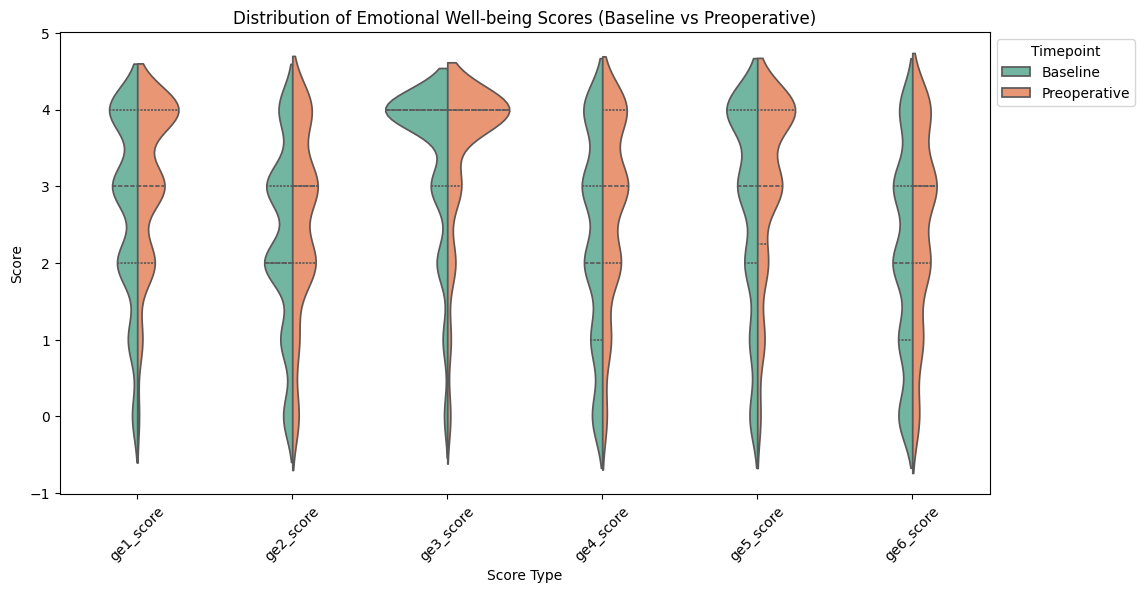

In [13]:
# === Violin Plot ===
plt.figure(figsize=(12, 6))
sns.violinplot(x="Score Type", y="Score", hue="Timepoint", data=combined_df, split=True, inner="quartile", palette="Set2")
plt.title("Distribution of Emotional Well-being Scores (Baseline vs Preoperative)")
plt.xticks(rotation=45)
plt.legend(title="Timepoint", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

# frequency of those that have both baseline and pre-operative FACT-E

In [47]:
# Identify patients who have both baseline and preoperative
patients_with_both = combined_df.groupby("id")["Timepoint"].unique()
patients_with_both = patients_with_both[patients_with_both.apply(lambda x: {"Baseline", "Preoperative"}.issubset(set(x)))].index

# Keep only rows where id is in the list of patients_with_both
filtered_df = combined_df[combined_df["id"].isin(patients_with_both)]

print(filtered_df)

score_distribution_by_timepoint2 = filtered_df.groupby(["Score", "Timepoint"]).size().unstack()
print(score_distribution_by_timepoint2)

         id Score Type  Score     Timepoint
84       55  ge1_score    2.0      Baseline
118      78  ge1_score    4.0      Baseline
190     125  ge1_score    3.0      Baseline
193     127  ge1_score    1.0      Baseline
195     128  ge1_score    4.0      Baseline
...     ...        ...    ...           ...
11669  1721  ge6_score    3.0  Preoperative
11672  1723  ge6_score    3.0  Preoperative
11676  1726  ge6_score    4.0  Preoperative
11679  1729  ge6_score    4.0  Preoperative
11694  1744  ge6_score    2.0  Preoperative

[3750 rows x 4 columns]
Timepoint  Baseline  Preoperative
Score                            
0.0             181            89
1.0             255           152
2.0             435           348
3.0             479           517
4.0             575           719


In [48]:
#Some patients can have more than one redcap_event - i.e. patient id 619
filtered_df[filtered_df['id']== 619]

,id,Score Type,Score,Timepoint
1014,619,ge1_score,2.0,Baseline
1015,619,ge1_score,4.0,Baseline
3777,619,ge2_score,2.0,Baseline
3778,619,ge2_score,2.0,Baseline
6540,619,ge3_score,3.0,Baseline
6541,619,ge3_score,3.0,Baseline
9303,619,ge4_score,1.0,Baseline
9304,619,ge4_score,3.0,Baseline
12066,619,ge5_score,1.0,Baseline
12067,619,ge5_score,3.0,Baseline


In [49]:
# Count the number of unique patients
num_patients_with_both = len(patients_with_both)

print(f"Number of patients with both Baseline and Preoperative: {num_patients_with_both}")

Number of patients with both Baseline and Preoperative: 280


In [50]:
ge_scores = ["ge1_score", "ge2_score", "ge3_score", "ge4_score", "ge5_score", "ge6_score"]

# Separate data by Timepoint
baseline_df_filtered = filtered_df[filtered_df["Timepoint"] == "Baseline"]
preoperative_df_filtered = filtered_df[filtered_df["Timepoint"] == "Preoperative"]

# Pivot table: Count occurrences of each Score for each Score Type
baseline_table = baseline_df_filtered.pivot_table(index="Score", columns="Score Type", aggfunc="size", fill_value=0)
preoperative_table = preoperative_df_filtered.pivot_table(index="Score", columns="Score Type", aggfunc="size", fill_value=0)

# Display the tables
print("Baseline Score Distribution Table:")
print(baseline_table)

print("\nPreoperative Score Distribution Table:")
print(preoperative_table)


Baseline Score Distribution Table:
Score Type  ge1_score  ge2_score  ge3_score  ge4_score  ge5_score  ge6_score
Score                                                                       
0.0                16         32          8         35         32         58
1.0                34         45         17         59         34         66
2.0                85        114         31         72         55         78
3.0                96         73         53         91         91         75
4.0                94         57        201         66        110         47

Preoperative Score Distribution Table:
Score Type  ge1_score  ge2_score  ge3_score  ge4_score  ge5_score  ge6_score
Score                                                                       
0.0                 6         26         10         15         10         22
1.0                15         26         12         31         24         44
2.0                56         88         28         65         41         70
3

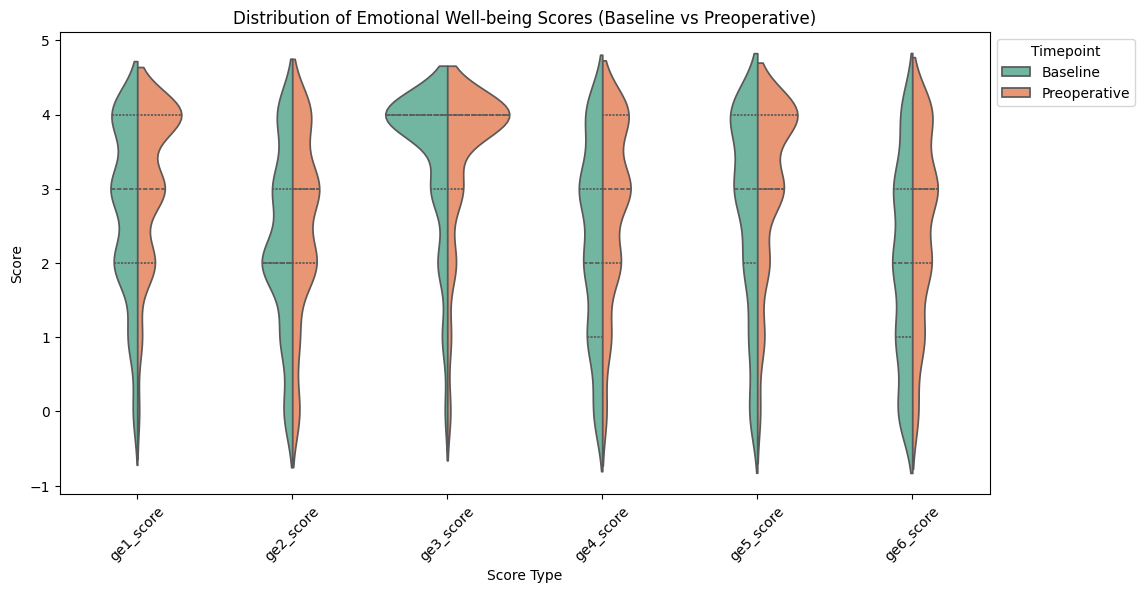

In [51]:
# === Violin Plot ===
plt.figure(figsize=(12, 6))
sns.violinplot(x="Score Type", y="Score", hue="Timepoint", data=filtered_df, split=True, inner="quartile", palette="Set2")
plt.title("Distribution of Emotional Well-being Scores (Baseline vs Preoperative)")
plt.xticks(rotation=45)
plt.legend(title="Timepoint", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

# calculate how many improve, stay the same, or decrease from baseline --> preop

In [19]:
filtered_df

,id,Score Type,Score,Timepoint
84,55,ge1_score,2.0,Baseline
118,78,ge1_score,4.0,Baseline
190,125,ge1_score,3.0,Baseline
193,127,ge1_score,1.0,Baseline
195,128,ge1_score,4.0,Baseline
...,...,...,...,...
11669,1721,ge6_score,3.0,Preoperative
11672,1723,ge6_score,3.0,Preoperative
11676,1726,ge6_score,4.0,Preoperative
11679,1729,ge6_score,4.0,Preoperative


In [20]:
# Average scores for duplicated (id, Score Type, Timepoint) entries
filtered_df_dup_avged = filtered_df.groupby(["id", "Score Type", "Timepoint"], as_index=False)["Score"].mean()
filtered_df_dup_avged

,id,Score Type,Timepoint,Score
0,55,ge1_score,Baseline,2.0
1,55,ge1_score,Preoperative,2.0
2,55,ge2_score,Baseline,2.0
3,55,ge2_score,Preoperative,2.0
4,55,ge3_score,Baseline,3.0
...,...,...,...,...
3325,1744,ge4_score,Preoperative,2.0
3326,1744,ge5_score,Baseline,4.0
3327,1744,ge5_score,Preoperative,4.0
3328,1744,ge6_score,Baseline,2.0


In [21]:
# Count expected number of rows per patient (should be 12 per patient)
expected_rows_per_patient = 12

# Count actual rows per patient
patient_counts = filtered_df_dup_avged.groupby("id").size()
patient_counts
# Identify patients who do NOT have exactly 12 rows
patients_missing_rows = patient_counts[patient_counts != expected_rows_per_patient]

# Display IDs and their actual row count
print("Patients with missing rows and their row count:")
print(patients_missing_rows)

Patients with missing rows and their row count:
id
260     11
548     10
566     11
788     11
826     11
898     11
1003    11
1012    11
1043    11
1106    11
1126     9
1313    11
1409    10
1551    11
1560    11
1629    11
1710     9
1715    11
1723     6
dtype: int64


In [22]:
# Pivot to make Score Types as columns and fill missing values with 0
pivot_df = filtered_df_dup_avged.pivot_table(index=["id", "Timepoint"], 
                                   columns="Score Type", 
                                   values="Score", 
                                   fill_value=0)

# Sum across all Score Types for each (id, Timepoint)
pivot_df["Total Score"] = pivot_df.sum(axis=1)

# Reset index to bring back "id" and "Timepoint" as columns
pivot_df = pivot_df.reset_index()
print(pivot_df)



# Count the number of non-missing values for each row (before replacing NaNs with 0)
num_answered = filtered_df_dup_avged.pivot_table(index=["id", "Timepoint"], 
                                       columns="Score Type", 
                                       values="Score", 
                                       aggfunc=lambda x: x.notna().sum())
num_answered

Score Type    id     Timepoint  ge1_score  ge2_score  ge3_score  ge4_score  \
0             55      Baseline        2.0        2.0        3.0        1.0   
1             55  Preoperative        2.0        2.0        3.0        4.0   
2             78      Baseline        4.0        2.0        4.0        2.0   
3             78  Preoperative        4.0        2.0        4.0        3.0   
4            125      Baseline        3.0        3.0        4.0        4.0   
..           ...           ...        ...        ...        ...        ...   
555         1726  Preoperative        3.0        3.0        4.0        4.0   
556         1729      Baseline        4.0        0.0        4.0        4.0   
557         1729  Preoperative        4.0        4.0        4.0        4.0   
558         1744      Baseline        3.0        4.0        4.0        2.0   
559         1744  Preoperative        4.0        4.0        4.0        2.0   

Score Type  ge5_score  ge6_score  Total Score  
0              

Score Type         ge1_score  ge2_score  ge3_score  ge4_score  ge5_score  \
id   Timepoint                                                             
55   Baseline            1.0        1.0        1.0        1.0        1.0   
     Preoperative        1.0        1.0        1.0        1.0        1.0   
78   Baseline            1.0        1.0        1.0        1.0        1.0   
     Preoperative        1.0        1.0        1.0        1.0        1.0   
125  Baseline            1.0        1.0        1.0        1.0        1.0   
...                      ...        ...        ...        ...        ...   
1726 Preoperative        1.0        1.0        1.0        1.0        1.0   
1729 Baseline            1.0        1.0        1.0        1.0        1.0   
     Preoperative        1.0        1.0        1.0        1.0        1.0   
1744 Baseline            1.0        1.0        1.0        1.0        1.0   
     Preoperative        1.0        1.0        1.0        1.0        1.0   

Score Type         ge6_score  
id   Timepoint                
55   Baseline            1.0  
     Preoperative        1.0  
78   Baseline            1.0  
     Preoperative        1.0  
125  Baseline            1.0  
...                      ...  
1726 Preoperative        1.0  
1729 Baseline            1.0  
     Preoperative        1.0  
1744 Baseline            1.0  
     Preoperative        1.0  

[560 rows x 6 columns]

In [23]:
#show the table where it is missing
num_answered[num_answered.sum(axis=1) != 6]

,Score Type,ge1_score,ge2_score,ge3_score,ge4_score,ge5_score,ge6_score
id,Timepoint,,,,,,
260,Baseline,1.0,1.0,NaN,1.0,1.0,1.0
548,Baseline,1.0,1.0,NaN,1.0,NaN,1.0
566,Baseline,1.0,1.0,NaN,1.0,1.0,1.0
788,Preoperative,1.0,1.0,NaN,1.0,1.0,1.0
826,Preoperative,1.0,1.0,1.0,1.0,1.0,NaN
898,Baseline,1.0,1.0,NaN,1.0,1.0,1.0
1003,Baseline,1.0,1.0,1.0,NaN,1.0,1.0
1012,Baseline,1.0,1.0,1.0,NaN,1.0,1.0
1043,Baseline,1.0,1.0,NaN,1.0,1.0,1.0


In [24]:
# Ensure num_answered has the same index as pivot_df
num_answered_sum = num_answered.sum(axis=1).reindex(pivot_df.set_index(["id", "Timepoint"]).index)

# Compute the Adjusted Score safely
pivot_df["EWB subscale Score"] = (pivot_df["Total Score"] * 6) / num_answered_sum.values


# Display result
pivot_df

Score Type,id,Timepoint,ge1_score,ge2_score,ge3_score,ge4_score,ge5_score,ge6_score,Total Score,EWB subscale Score
0,55,Baseline,2.0,2.0,3.0,1.0,0.0,0.0,8.0,8.0
1,55,Preoperative,2.0,2.0,3.0,4.0,2.0,1.0,14.0,14.0
2,78,Baseline,4.0,2.0,4.0,2.0,4.0,1.0,17.0,17.0
3,78,Preoperative,4.0,2.0,4.0,3.0,4.0,3.0,20.0,20.0
4,125,Baseline,3.0,3.0,4.0,4.0,4.0,3.0,21.0,21.0
...,...,...,...,...,...,...,...,...,...,...
555,1726,Preoperative,3.0,3.0,4.0,4.0,4.0,4.0,22.0,22.0
556,1729,Baseline,4.0,0.0,4.0,4.0,4.0,2.0,18.0,18.0
557,1729,Preoperative,4.0,4.0,4.0,4.0,4.0,4.0,24.0,24.0
558,1744,Baseline,3.0,4.0,4.0,2.0,4.0,2.0,19.0,19.0


In [25]:
# Pivot to get baseline and preoperative scores side by side
score_comparison = pivot_df.pivot(index="id", columns="Timepoint", values="EWB subscale Score")

# Compute the change: preoperative - baseline
score_comparison["Change"] = score_comparison["Preoperative"] - score_comparison["Baseline"]

# Categorize improvement, no change, or decline
score_comparison["Trend"] = score_comparison["Change"].apply(
    lambda x: "Improved" if x > 0 else "Same" if x == 0 else "Decreased"
)

# Display result
print(score_comparison[["Baseline", "Preoperative", "Change", "Trend"]])


Timepoint  Baseline  Preoperative  Change      Trend
id                                                  
55              8.0          14.0     6.0   Improved
78             17.0          20.0     3.0   Improved
125            21.0          16.0    -5.0  Decreased
127             5.0          12.0     7.0   Improved
128            22.0          23.0     1.0   Improved
...             ...           ...     ...        ...
1721           12.0          19.0     7.0   Improved
1723           18.0          18.0     0.0       Same
1726           21.0          22.0     1.0   Improved
1729           18.0          24.0     6.0   Improved
1744           19.0          20.0     1.0   Improved

[280 rows x 4 columns]


/tmp/ipykernel_370573/3921134547.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=["green", "gray", "red"])


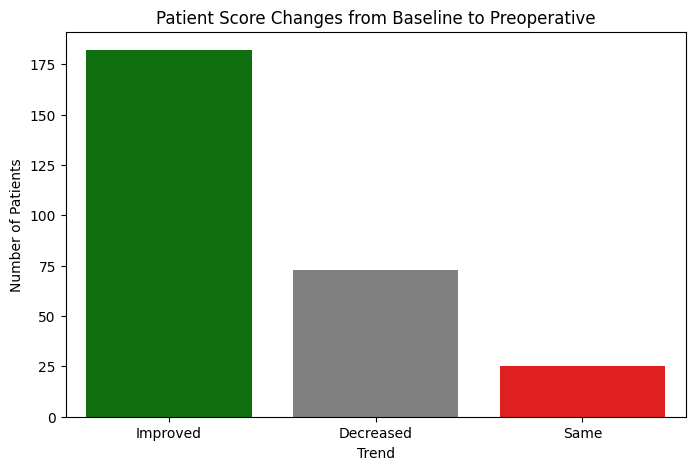

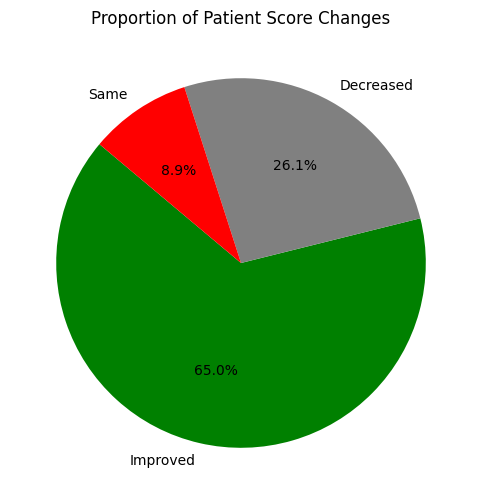

In [26]:
# Count the number of patients in each category
trend_counts = score_comparison["Trend"].value_counts()

# === 1. Bar Plot ===
plt.figure(figsize=(8, 5))
sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=["green", "gray", "red"])
plt.title("Patient Score Changes from Baseline to Preoperative")
plt.xlabel("Trend")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.show()

# === 2. Pie Chart ===
plt.figure(figsize=(6, 6))
plt.pie(trend_counts, labels=trend_counts.index, autopct="%1.1f%%", colors=["green", "gray", "red"], startangle=140)
plt.title("Proportion of Patient Score Changes")
plt.show()


# Categorize patients into: 1) improvers or 2) decliners / stay the same

In [27]:
score_comparison

Timepoint,Baseline,Preoperative,Change,Trend
id,,,,
55,8.0,14.0,6.0,Improved
78,17.0,20.0,3.0,Improved
125,21.0,16.0,-5.0,Decreased
127,5.0,12.0,7.0,Improved
128,22.0,23.0,1.0,Improved
...,...,...,...,...
1721,12.0,19.0,7.0,Improved
1723,18.0,18.0,0.0,Same
1726,21.0,22.0,1.0,Improved


In [28]:
# Re-categorize into two groups
score_comparison["Trend Category"] = score_comparison["Change"].apply(lambda x: "Improved" if x > 0 else "Decreased/Same")

score_comparison

Timepoint,Baseline,Preoperative,Change,Trend,Trend Category
id,,,,,
55,8.0,14.0,6.0,Improved,Improved
78,17.0,20.0,3.0,Improved,Improved
125,21.0,16.0,-5.0,Decreased,Decreased/Same
127,5.0,12.0,7.0,Improved,Improved
128,22.0,23.0,1.0,Improved,Improved
...,...,...,...,...,...
1721,12.0,19.0,7.0,Improved,Improved
1723,18.0,18.0,0.0,Same,Decreased/Same
1726,21.0,22.0,1.0,Improved,Improved


In [29]:
trend_counts = score_comparison["Trend Category"].value_counts()
trend_counts

Trend Category
Improved          182
Decreased/Same     98
Name: count, dtype: int64

/tmp/ipykernel_370573/3720356275.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=["green", "red"])


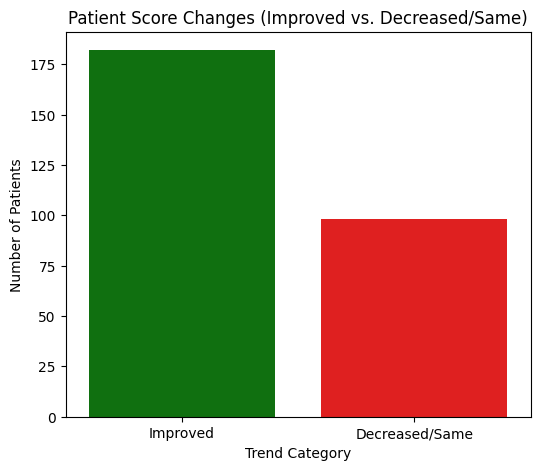

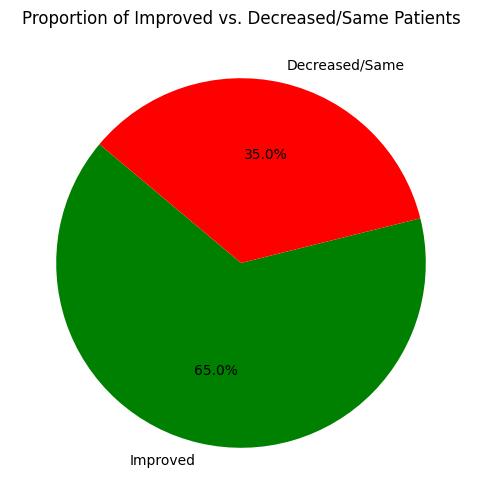

In [30]:
# === 1. Bar Plot ===
plt.figure(figsize=(6, 5))
sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=["green", "red"])
plt.title("Patient Score Changes (Improved vs. Decreased/Same)")
plt.xlabel("Trend Category")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.show()

# === 2. Pie Chart ===
plt.figure(figsize=(6, 6))
plt.pie(trend_counts, labels=trend_counts.index, autopct="%1.1f%%", colors=["green", "red"], startangle=140)
plt.title("Proportion of Improved vs. Decreased/Same Patients")
plt.show()

# statistically significantly associated with 1) occurrence of adverse events (postop_comp)

In [31]:
score_comparison

Timepoint,Baseline,Preoperative,Change,Trend,Trend Category
id,,,,,
55,8.0,14.0,6.0,Improved,Improved
78,17.0,20.0,3.0,Improved,Improved
125,21.0,16.0,-5.0,Decreased,Decreased/Same
127,5.0,12.0,7.0,Improved,Improved
128,22.0,23.0,1.0,Improved,Improved
...,...,...,...,...,...
1721,12.0,19.0,7.0,Improved,Improved
1723,18.0,18.0,0.0,Same,Decreased/Same
1726,21.0,22.0,1.0,Improved,Improved


In [32]:
# Merge score_comparison with postop_comp data (assuming both have "id" as a common key)
merged_df = score_comparison.merge(df_extracted[["id", "postop_comp"]], on="id", how="left")
# Remove rows where postop_comp is missing
merged_df_removedNA = merged_df.dropna(subset=["postop_comp"])
print(merged_df_removedNA)

        id  Baseline  Preoperative  Change      Trend  Trend Category  \
6       55       8.0          14.0     6.0   Improved        Improved   
13      78      17.0          20.0     3.0   Improved        Improved   
22     125      21.0          16.0    -5.0  Decreased  Decreased/Same   
42     141      20.0          20.0     0.0       Same  Decreased/Same   
50     158      19.0          21.0     2.0   Improved        Improved   
...    ...       ...           ...     ...        ...             ...   
1876  1551      15.6          18.0     2.4   Improved        Improved   
1902  1570       8.0          13.0     5.0   Improved        Improved   
1927  1577      14.0           6.0    -8.0  Decreased  Decreased/Same   
1937  1591      19.0          20.0     1.0   Improved        Improved   
1944  1597      12.0          17.0     5.0   Improved        Improved   

      postop_comp  
6             0.0  
13            1.0  
22            0.0  
42            0.0  
50            1.0  
...

### Chi-square test

In [33]:
# Create a contingency table
contingency_table = pd.crosstab(merged_df_removedNA["Trend Category"], merged_df_removedNA["postop_comp"])
print(contingency_table)

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print results
print("Chi-Square Statistic:", chi2)
print("p-value:", p)

postop_comp     0.0  1.0
Trend Category          
Decreased/Same   23   27
Improved         40   44
Chi-Square Statistic: 7.13274355125401e-06
p-value: 0.9978690765429644


### Fisher's exact test

In [34]:
odds_ratio, p_value = stats.fisher_exact(contingency_table)
print(f"Fisher's Exact Test p-value: {p_value}")

Fisher's Exact Test p-value: 1.0


### Logistic test

In [35]:
# Convert categorical variable to binary (1 = Improved, 0 = Decreased/Same)
merged_df_removedNA["Trend Binary"] = (merged_df_removedNA["Trend Category"] == "Improved").astype(int)

# Logistic Regression Model
X = sm.add_constant(merged_df_removedNA["Trend Binary"])  # Predictor
y = merged_df_removedNA["postop_comp"]  # Outcome (0/1)

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.691241
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:            postop_comp   No. Observations:                  134
Model:                          Logit   Df Residuals:                      132
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Feb 2025   Pseudo R-squ.:               0.0001781
Time:                        12:24:27   Log-Likelihood:                -92.626
converged:                       True   LL-Null:                       -92.643
Covariance Type:            nonrobust   LLR p-value:                    0.8559
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1603      0.284      0.565      0.572      -0.396       0.716
Trend Binary    -0.0650

/tmp/ipykernel_370573/2525454881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_removedNA["Trend Binary"] = (merged_df_removedNA["Trend Category"] == "Improved").astype(int)


postop_comp         0.0      1.0
Trend Category                  
Decreased/Same  0.46000  0.54000
Improved        0.47619  0.52381


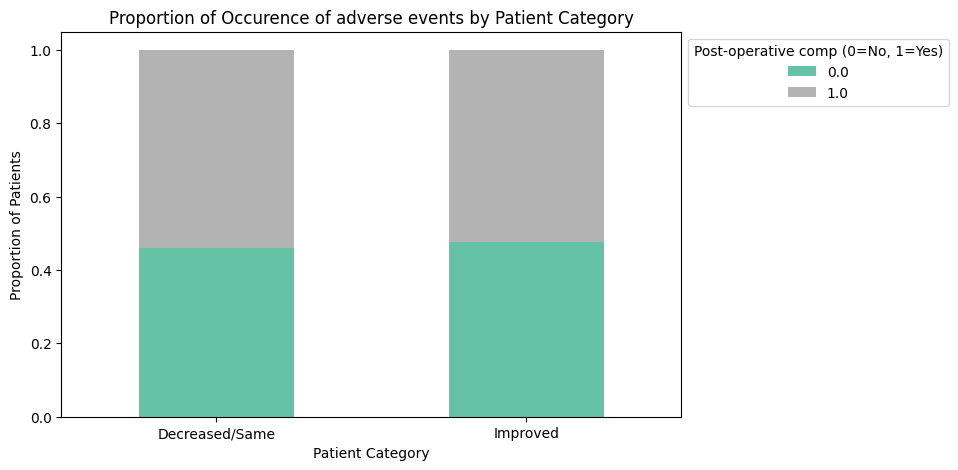

In [36]:
# Create proportion table
proportions = merged_df_removedNA.groupby("Trend Category")["postop_comp"].value_counts(normalize=True).unstack()
print(proportions)
# Plot bar chart
proportions.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 5))
plt.xlabel("Patient Category")
plt.ylabel("Proportion of Patients")
plt.title("Proportion of Occurence of adverse events by Patient Category")
plt.legend(title="Post-operative comp (0=No, 1=Yes)",  bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.show()


# statistically significantly associated with 2) hospital length of stay (los)

In [53]:
# Merge score_comparison with los data (assuming both have "id" as a common key)
merged_df_los = score_comparison.merge(df_extracted[["id", "los"]], on="id", how="left")

# Remove rows where los is missing
merged_df_removedNA_los = merged_df_los.dropna(subset=["los"])
print(merged_df_removedNA_los)

        id  Baseline  Preoperative  Change      Trend  Trend Category   los
6       55       8.0          14.0     6.0   Improved        Improved   6.0
13      78      17.0          20.0     3.0   Improved        Improved   7.0
22     125      21.0          16.0    -5.0  Decreased  Decreased/Same  16.0
42     141      20.0          20.0     0.0       Same  Decreased/Same   7.0
58     160      21.0          20.0    -1.0  Decreased  Decreased/Same  24.0
...    ...       ...           ...     ...        ...             ...   ...
1876  1551      15.6          18.0     2.4   Improved        Improved   7.0
1902  1570       8.0          13.0     5.0   Improved        Improved   6.0
1927  1577      14.0           6.0    -8.0  Decreased  Decreased/Same   9.0
1937  1591      19.0          20.0     1.0   Improved        Improved   7.0
1944  1597      12.0          17.0     5.0   Improved        Improved   6.0

[106 rows x 7 columns]


In [54]:
# Count the number of occurrences for each Trend Category
trend_category_counts = merged_df_removedNA_los["Trend Category"].value_counts()

# Calculate the average Change for each Trend Category
avg_change_by_category = merged_df_removedNA_los.groupby("Trend Category")["Change"].mean()

# Print results
print("Count of each Trend Category:")
print(trend_category_counts)

print("\nAverage Change for each Trend Category:")
print(avg_change_by_category)


Count of each Trend Category:
Trend Category
Improved          67
Decreased/Same    39
Name: count, dtype: int64

Average Change for each Trend Category:
Trend Category
Decreased/Same   -2.778632
Improved          5.118905
Name: Change, dtype: float64


In [59]:
merged_df_removedNA_los.groupby("Trend Category")[["Change"]].describe()

Change                                                
                count      mean       std   min   25%  50%  75%   max
Trend Category                                                       
Decreased/Same   39.0 -2.778632  2.761054 -10.0 -4.75 -2.0  0.0   0.0
Improved         67.0  5.118905  3.309583   0.5  3.00  4.0  7.0  14.0

In [38]:
# Separate hospital length of stay (los) values by Trend Category
los_improved = merged_df_removedNA_los.loc[merged_df_removedNA_los["Trend Category"] == "Improved", "los"]
los_not_improved = merged_df_removedNA_los.loc[merged_df_removedNA_los["Trend Category"] == "Decreased/Same", "los"]

# Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(los_improved, los_not_improved, alternative="two-sided")

print(f"Mann-Whitney U Test statistic: {u_stat}")
print(f"Mann-Whitney U Test p-value: {p_value}")

Mann-Whitney U Test statistic: 1011.5
Mann-Whitney U Test p-value: 0.04348815906828692


In [39]:
# Calculate mean LOS for each category
avg_los_improved = los_improved.mean()
avg_los_not_improved = los_not_improved.mean()

print(f"Average LOS for Improved: {avg_los_improved:.2f}")
print(f"Average LOS for Not Improved: {avg_los_not_improved:.2f}")

Average LOS for Improved: 9.19
Average LOS for Not Improved: 10.38


/tmp/ipykernel_370573/2754884328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_removedNA_los["Trend Category_binary"] = merged_df_removedNA_los["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})
/tmp/ipykernel_370573/2754884328.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Trend Category", y="los", data=merged_df_removedNA_los, palette="Set2")


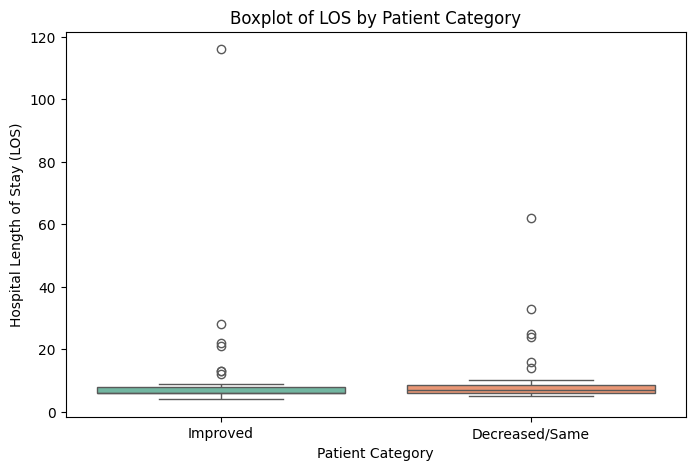

/tmp/ipykernel_370573/2754884328.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Trend Category", y="los", data=merged_df_removedNA_los, palette="Set2", inner="quartile")


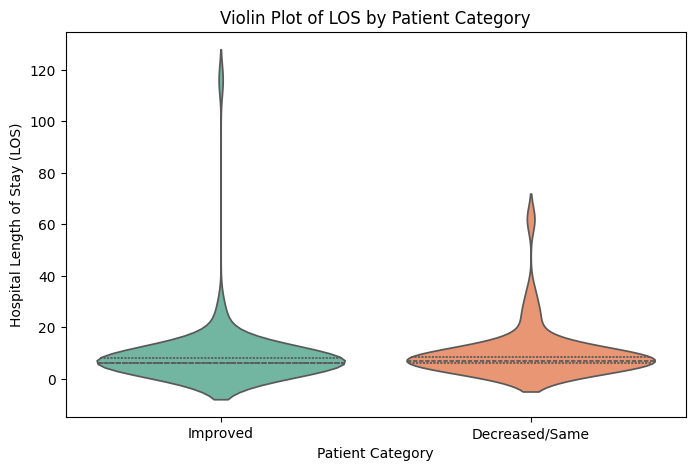

In [40]:
# Encode Trend Category as binary
merged_df_removedNA_los["Trend Category_binary"] = merged_df_removedNA_los["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})

## ==== Boxplot ====
plt.figure(figsize=(8, 5))
sns.boxplot(x="Trend Category", y="los", data=merged_df_removedNA_los, palette="Set2")
plt.xlabel("Patient Category")
plt.ylabel("Hospital Length of Stay (LOS)")
plt.title("Boxplot of LOS by Patient Category")
plt.show()

## ==== Violin Plot ====
plt.figure(figsize=(8, 5))
sns.violinplot(x="Trend Category", y="los", data=merged_df_removedNA_los, palette="Set2", inner="quartile")
plt.xlabel("Patient Category")
plt.ylabel("Hospital Length of Stay (LOS)")
plt.title("Violin Plot of LOS by Patient Category")
plt.show()

/tmp/ipykernel_370573/2787230377.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Trend Category", y="los", data=filtered_df, palette="Set2")


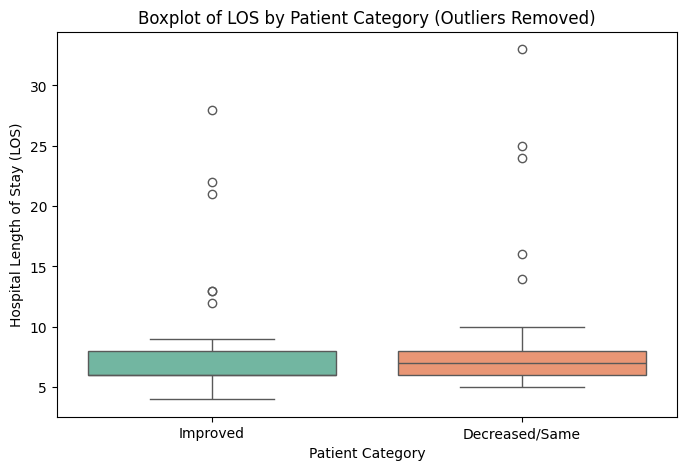

/tmp/ipykernel_370573/2787230377.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Trend Category", y="los", data=filtered_df, palette="Set2", inner="quartile")


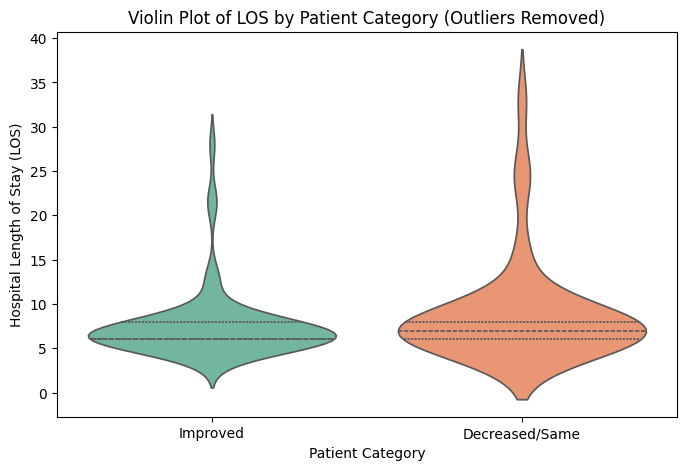

In [41]:
# Remove the highest LOS value in both groups
max_improved_los = merged_df_removedNA_los.loc[merged_df_removedNA_los["Trend Category"] == "Improved", "los"].max()
max_not_improved_los = merged_df_removedNA_los.loc[merged_df_removedNA_los["Trend Category"] == "Decreased/Same", "los"].max()

filtered_df = merged_df_removedNA_los[
    ~((merged_df_removedNA_los["Trend Category"] == "Improved") & (merged_df_removedNA_los["los"] == max_improved_los)) &
    ~((merged_df_removedNA_los["Trend Category"] == "Decreased/Same") & (merged_df_removedNA_los["los"] == max_not_improved_los))
]

## ==== Boxplot (Without Outliers) ====
plt.figure(figsize=(8, 5))
sns.boxplot(x="Trend Category", y="los", data=filtered_df, palette="Set2")
plt.xlabel("Patient Category")
plt.ylabel("Hospital Length of Stay (LOS)")
plt.title("Boxplot of LOS by Patient Category (Outliers Removed)")
plt.show()

## ==== Violin Plot (Without Outliers) ====
plt.figure(figsize=(8, 5))
sns.violinplot(x="Trend Category", y="los", data=filtered_df, palette="Set2", inner="quartile")
plt.xlabel("Patient Category")
plt.ylabel("Hospital Length of Stay (LOS)")
plt.title("Violin Plot of LOS by Patient Category (Outliers Removed)")
plt.show()


# statistically significantly associated with 3) 30-day hospital readmission rate (readmission_30d)

In [42]:
# Merge score_comparison with readmission_30d data (assuming both have "id" as a common key)
merged_df_30re = score_comparison.merge(df_extracted[["id", "readmission_30d"]], on="id", how="left")

# Remove rows where readmission_30d is missing
merged_df_removedNA_30re = merged_df_30re.dropna(subset=["readmission_30d"])
print(merged_df_removedNA_30re)

        id  Baseline  Preoperative  Change      Trend  Trend Category  \
6       55       8.0          14.0     6.0   Improved        Improved   
13      78      17.0          20.0     3.0   Improved        Improved   
22     125      21.0          16.0    -5.0  Decreased  Decreased/Same   
42     141      20.0          20.0     0.0       Same  Decreased/Same   
58     160      21.0          20.0    -1.0  Decreased  Decreased/Same   
...    ...       ...           ...     ...        ...             ...   
1823  1433      17.0          18.0     1.0   Improved        Improved   
1876  1551      15.6          18.0     2.4   Improved        Improved   
1902  1570       8.0          13.0     5.0   Improved        Improved   
1927  1577      14.0           6.0    -8.0  Decreased  Decreased/Same   
1944  1597      12.0          17.0     5.0   Improved        Improved   

      readmission_30d  
6                 0.0  
13                0.0  
22                0.0  
42                0.0  
58 

### Chi-square test

In [43]:
# Create a contingency table
contingency_table_30re = pd.crosstab(merged_df_removedNA_30re["Trend Category"], merged_df_removedNA_30re["readmission_30d"])
print(contingency_table_30re)

# Chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table_30re)

print(f"Chi-Square Test p-value: {p_value}")


readmission_30d  0.0  1.0
Trend Category           
Decreased/Same    40    7
Improved          68   10
Chi-Square Test p-value: 0.9536071198998736


### Fisher's exact test

In [44]:
odds_ratio, p_value = stats.fisher_exact(contingency_table_30re)
print(f"Fisher's Exact Test p-value: {p_value}")

Fisher's Exact Test p-value: 0.79097261737525


### Logistic test

In [45]:
# Convert categorical variable to binary (1 = Improved, 0 = Decreased/Same)
merged_df_removedNA_30re["Trend Category_binary"] = merged_df_removedNA_30re["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})

# Logistic Regression Model
X = sm.add_constant(merged_df_removedNA_30re["Trend Category_binary"])  # Predictor
y = merged_df_removedNA_30re["readmission_30d"]  # Outcome (0/1)

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.397210
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        readmission_30d   No. Observations:                  125
Model:                          Logit   Df Residuals:                      123
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Feb 2025   Pseudo R-squ.:                0.001069
Time:                        12:24:31   Log-Likelihood:                -49.651
converged:                       True   LL-Null:                       -49.704
Covariance Type:            nonrobust   LLR p-value:                    0.7445
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.7430      0.410     -4.254      0.000      -2.546      -0.

/tmp/ipykernel_370573/2742517897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_removedNA_30re["Trend Category_binary"] = merged_df_removedNA_30re["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})


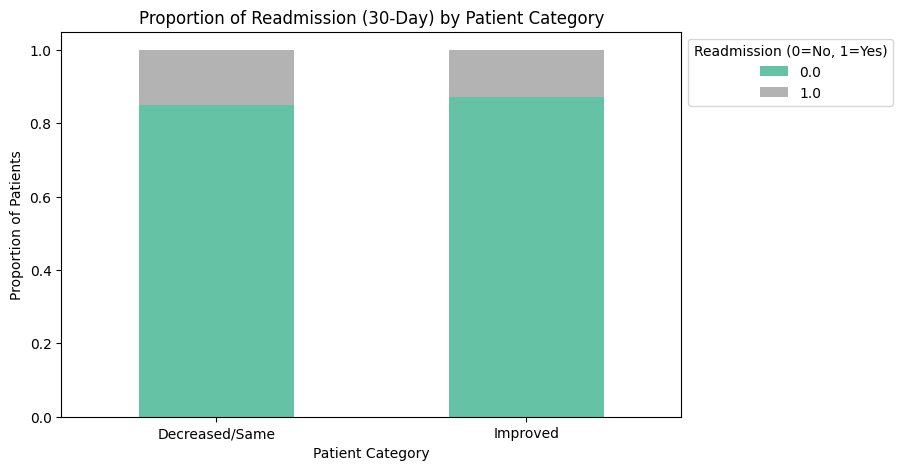

In [46]:
# Create proportion table
proportions = merged_df_removedNA_30re.groupby("Trend Category")["readmission_30d"].value_counts(normalize=True).unstack()

# Plot bar chart
proportions.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 5))
plt.xlabel("Patient Category")
plt.ylabel("Proportion of Patients")
plt.title("Proportion of Readmission (30-Day) by Patient Category")
plt.legend(title="Readmission (0=No, 1=Yes)", bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.show()
